In [1]:
import pandas as pd

# Adjust the file path as necessary
train_data_path = '/Users/ieon71/Desktop/HW2/data_train-1.csv'  
test_data_path = '/Users/ieon71/Desktop/HW2/data_test-1.csv'  
#train_data_path = 'data_train-1.csv'
#test_data_path = 'data_test-1.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)


In [2]:
train_data.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP001518,Male,Yes,1,Graduate,No,1538,1425.0,30.0,360.0,1.0,Urban,Y
1,1,LP002734,Male,Yes,0,Graduate,No,6133,3906.0,324.0,360.0,1.0,Urban,Y
2,2,LP002697,Male,No,0,Graduate,No,4680,2087.0,NaN,360.0,1.0,Semiurban,N
3,3,LP002455,Male,Yes,2,Graduate,No,3859,0.0,96.0,360.0,1.0,Semiurban,Y
4,4,LP001732,Male,Yes,2,Graduate,NaN,5000,0.0,72.0,360.0,0.0,Semiurban,N


There are 14 columns in the table. The last column is the label, the first column is the row number, and the remaining 12 columns are attributes

In [3]:
# Drop the unnamed and loan_id, load_id is irrelevent to the result
train_data = train_data.drop(['Unnamed: 0', 'Loan_ID'],axis=1)
test_data = test_data.drop(['Unnamed: 0', 'Loan_ID'],axis=1)

In [4]:
print(f"Shape of Training Data: {train_data.shape}")
print(f"Shape of Test Data: {test_data.shape}")

Shape of Training Data: (491, 12)
Shape of Test Data: (123, 11)


In [5]:
train_data.isnull().sum(),test_data.isnull().sum()

(Gender               12
 Married               3
 Dependents           13
 Education             0
 Self_Employed        29
 ApplicantIncome       0
 CoapplicantIncome     0
 LoanAmount           17
 Loan_Amount_Term     12
 Credit_History       43
 Property_Area         0
 Loan_Status           0
 dtype: int64,
 Gender               1
 Married              0
 Dependents           2
 Education            0
 Self_Employed        3
 ApplicantIncome      0
 CoapplicantIncome    0
 LoanAmount           5
 Loan_Amount_Term     2
 Credit_History       7
 Property_Area        0
 dtype: int64)

In [6]:
train_data_cleaned = train_data.dropna()
train_data_cleaned.head()
test_data = test_data.dropna()
train_data.shape, test_data.shape

((491, 12), (107, 11))

In [7]:
X_train = train_data_cleaned.drop(['Loan_Status'], axis=1) 
y_train = train_data_cleaned['Loan_Status']

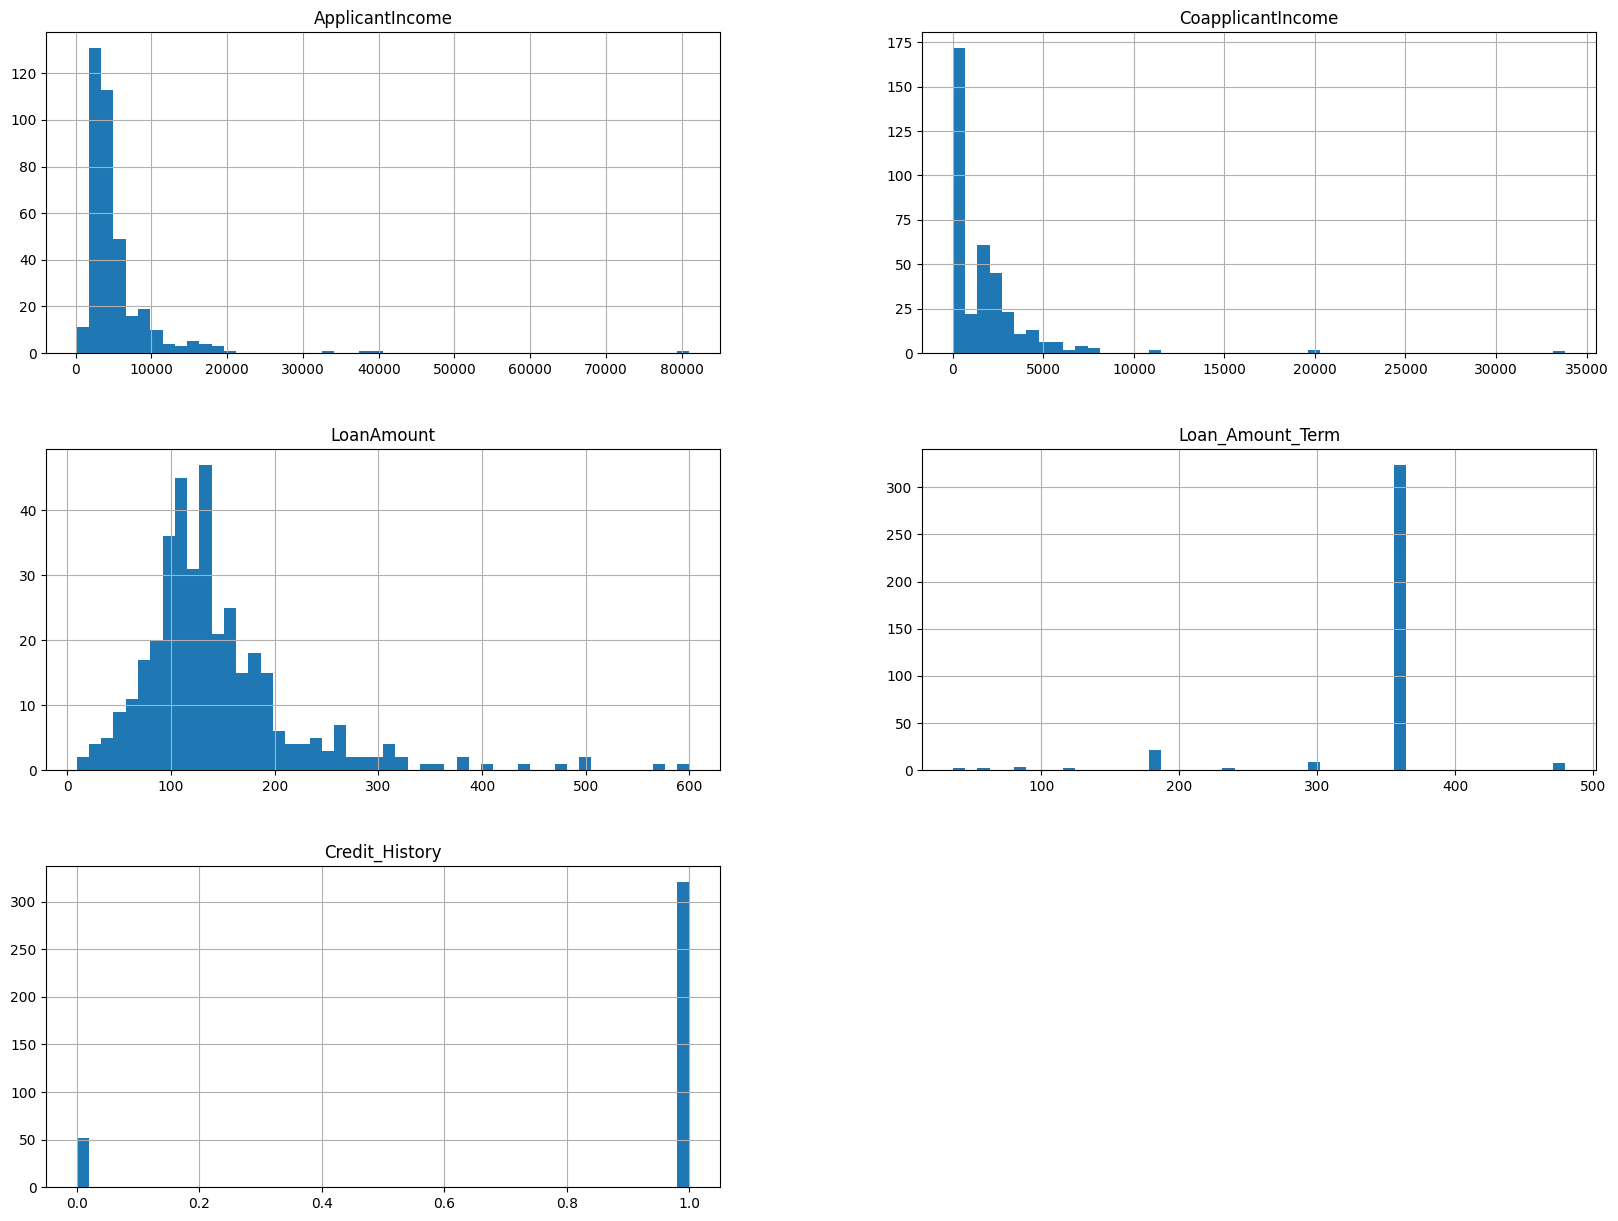

In [8]:
import matplotlib.pyplot as plt

train_data_cleaned.hist(bins=50, figsize=(20,15))
plt.show()


In [9]:
print(X_train.dtypes)

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object


In [10]:
from sklearn.preprocessing import LabelEncoder
var_names = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
for name in var_names:
    le = LabelEncoder()
    X_train[name] = le.fit_transform(X_train[name])
    test_data[name] = le.transform(test_data[name])

le = LabelEncoder()
y_train = le.fit_transform(y_train)
X_train.dtypes

Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
dtype: object

We use label encoding because these variables are all categorical variables.

In [11]:
def gini_index(groups, classes): 
    cnt = float(sum([len(group) for group in groups])) 
    gini = 0.0
    for group in groups:
        if len(group) == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / float(len(group))
            score += p * p 
        gini += (1.0 - score) * (float(len(group)) / cnt)
    return gini


def make_leaf_node(group):
    labels = [row[-1] for row in group]
    return max(labels, key=labels.count)

def make_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    best_index, best_val, best_score, best_groups = None, None, None, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            left, right = list(), list()
            value = row[index]
            for _row in dataset:
                if _row[index] < value:
                    left.append(_row)
                else:
                    right.append(_row)
            groups = (left, right)
            gini_score = gini_index(groups, class_values)
            if best_score is None or gini_score < best_score:
                best_index, best_val, best_score, best_groups = index, row[index], gini_score, groups
    return {'index':best_index, 'value':best_val, 'groups':best_groups}


def split(node, max_depth, min_size, depth):
    left, right = node['groups']

    if len(left) == 0 or len(right) == 0:
        node['left'] = node['right'] = make_leaf_node(left + right)
        return

    if depth >= max_depth:
        node['left'], node['right'] = make_leaf_node(left), make_leaf_node(right)
        return

    if len(left) <= min_size:
        node['left'] = make_leaf_node(left)
    else:
        node['left'] = make_split(left)
        split(node['left'], max_depth, min_size, depth+1)

    if len(right) <= min_size:
        node['right'] = make_leaf_node(right)
    else:
        node['right'] = make_split(right)
        split(node['right'], max_depth, min_size, depth+1)

def build_tree(train, max_depth, min_size):
    root = make_split(train)
    split(root, max_depth, min_size, 1)
    return root


def predict(node, row):
    if not isinstance(node, dict):
        return node
    if row[node['index']] < node['value']:
        return predict(node['left'], row)
    else:
        return predict(node['right'], row)



In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_set = pd.concat([X_train_part.reset_index(drop=True), pd.DataFrame(y_train_part)], axis=1).values.tolist()
validation_set = pd.concat([X_val.reset_index(drop=True), pd.DataFrame(y_val)], axis=1).values.tolist()

tree = build_tree(train_set, max_depth=5, min_size=10)

predictions = [predict(tree, row) for row in validation_set]


In [13]:
sum(y_val == predictions) / len(predictions)

0.7733333333333333

Accucary in validation set is 77%.

In [14]:
test_data_list = test_data.values.tolist()

predictions = [int(predict(tree, row)) for row in test_data_list]
predictions = le.inverse_transform(predictions)
pred_df = pd.DataFrame(predictions, columns=['pred_tree'])
pred_df.to_csv('FirstName_LastName_preds.csv', index=False)


### Part B

In [15]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

def train_xgboost(X_train, y_train, lambdas):
    auc_scores = {}
    for lam in lambdas:
        model = xgb.XGBClassifier(reg_lambda=lam)
        auc = cross_val_score(model, X_train, y_train, scoring=make_scorer(roc_auc_score, needs_proba=True), cv=10).mean()
        auc_scores[lam] = auc
    return auc_scores

lambdas = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

auc_scores = train_xgboost(X_train_part, y_train_part, lambdas)
print(auc_scores)


{0.001: 0.7704603174603175, 0.01: 0.7596428571428572, 0.1: 0.7658703703703704, 1: 0.773420634920635, 10: 0.7923597883597884, 100: 0.7863783068783069, 1000: 0.748568783068783}


In [16]:
optimal_lambda = max(auc_scores, key=auc_scores.get)
best_model = xgb.XGBClassifier(reg_lambda=optimal_lambda)
best_model.fit(X_train_part, y_train_part)
y_pred = best_model.predict_proba(X_val)[:, 1]


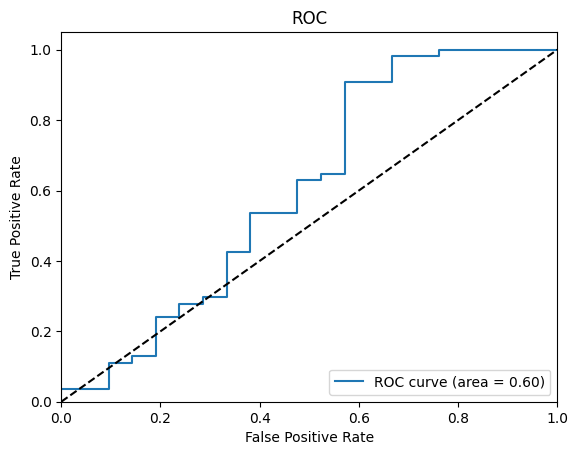

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [18]:
y_pred = best_model.predict(X_val) 

sum(y_val ==  y_pred)/len(y_val)

0.7466666666666667

From the perspective of accuracy, we should choose the parta part of the model. This may be because the relationship between the data is not complicated.

In [19]:
test_predictions = best_model.predict(test_data)  
original_labels = le.inverse_transform(test_predictions)

predictions_df = pd.DataFrame(original_labels, columns=['pred_xgboost'])
predictions_df = pd.concat([predictions_df, pred_df], axis = 1)
predictions_df.to_csv('FirstName_LastName_preds.csv', index=False)
